In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
!unzip archive

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: valid/truck/n03632852_1173.png  
  inflating: valid/truck/n03632852_11766.png  
  inflating: valid/truck/n03632852_11887.png  
  inflating: valid/truck/n03632852_1191.png  
  inflating: valid/truck/n03632852_1192.png  
  and more, manually removing in order to clear the screen 
  inflating: valid/truck/n04520170_9800.png  
  inflating: valid/truck/n04520170_9801.png  
  inflating: valid/truck/n04520170_9830.png  
  inflating: valid/truck/n04520170_9880.png  


In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
set_seed()

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

In [6]:
train_set = ImageFolder(root='train//', transform=transform)
validate_set = ImageFolder(root='valid//', transform=transform)
test_set = ImageFolder(root='test//', transform=transform)

In [7]:
class_names = train_set.classes
num_labels = len(class_names)

In [8]:
data_loader = DataLoader(train_set, batch_size=64, num_workers=2, pin_memory=True, shuffle=True)
data_loader_val = DataLoader(validate_set, batch_size=64, num_workers=2, pin_memory=True, shuffle=False)
data_loader_test = DataLoader(test_set, batch_size=64, num_workers=2, shuffle=False)

In [ ]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return 0 (or GPU index)
print(torch.cuda.get_device_name(0))  # Should return GPU name (e.g., Tesla T4)

True
0
Tesla T4


# DenseNet-121

The next model is DenseNet-121.

In [9]:
from torchvision.models import densenet121


In [10]:
model = densenet121()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [12]:
model.features.conv0 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.features.pool0 = nn.Identity()
model.classifier = nn.Linear(1024, num_labels)

In [13]:
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): Identity()
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 128, kernel_s

In [14]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device)
        Y = batch_Y.to(device)

        outputs = model(X)
        loss = criterion(outputs, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)

    avg_loss = total_loss / len(data_loader)
    train_accuracy = correct / total * 100
    print(f"Epoch number {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device)
            Y = batch_Y.to(device)

            outputs = model(X)
            loss = criterion(outputs, Y)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)

    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

Epoch number 1, Loss: 0.9994, Accuracy: 64.01%
Epoch 1, Validation Loss: 1.0216, Accuracy: 63.94%
Epoch number 2, Loss: 0.8151, Accuracy: 70.83%
Epoch 2, Validation Loss: 0.8499, Accuracy: 68.66%
Epoch number 3, Loss: 0.6957, Accuracy: 75.24%
Epoch 3, Validation Loss: 0.8077, Accuracy: 71.48%
Epoch number 4, Loss: 0.6014, Accuracy: 78.53%
Epoch 4, Validation Loss: 0.7340, Accuracy: 73.75%
Epoch number 5, Loss: 0.5204, Accuracy: 81.31%
Epoch 5, Validation Loss: 0.6912, Accuracy: 75.91%
Epoch number 6, Loss: 0.4418, Accuracy: 84.17%
Epoch 6, Validation Loss: 0.7123, Accuracy: 75.58%
Epoch number 7, Loss: 0.3728, Accuracy: 86.66%
Epoch 7, Validation Loss: 0.6851, Accuracy: 77.38%
Epoch number 8, Loss: 0.3052, Accuracy: 89.08%
Epoch 8, Validation Loss: 0.7101, Accuracy: 77.54%
Epoch number 9, Loss: 0.2474, Accuracy: 91.12%
Epoch 9, Validation Loss: 0.7482, Accuracy: 77.79%
Epoch number 10, Loss: 0.2018, Accuracy: 92.83%
Epoch 10, Validation Loss: 0.8068, Accuracy: 77.79%
Epoch number 11, L

In [15]:
train_losses = [0.9994, 0.8151, 0.6957, 0.6014, 0.5204, 0.4418, 0.3728, 0.3052, 0.2474, 0.2018,
                0.1676, 0.1403, 0.1239, 0.1121, 0.0989, 0.0973, 0.0917, 0.0790, 0.0781, 0.0763,
                0.0700, 0.0709, 0.0650, 0.0650, 0.0623, 0.0606, 0.0578, 0.0575, 0.0539, 0.0555]
train_accuracies = [64.01, 70.83, 75.24, 78.53, 81.31, 84.17, 86.66, 89.08, 91.12, 92.83,
                    93.94, 94.93, 95.65, 96.06, 96.48, 96.63, 96.72, 97.19, 97.21, 97.33,
                    97.51, 97.51, 97.70, 97.77, 97.82, 97.93, 97.92, 98.00, 98.10, 98.04]
val_losses = [1.0216, 0.8499, 0.8077, 0.7340, 0.6912, 0.7123, 0.6851, 0.7101, 0.7482, 0.8068,
              0.8520, 0.8979, 0.9962, 0.9449, 0.9657, 0.9958, 0.9321, 0.9832, 0.9911, 1.0643,
              1.0503, 1.0690, 1.0795, 1.0789, 1.1082, 1.0069, 1.0794, 1.0450, 1.0649, 1.0787]
val_accuracies = [63.94, 68.66, 71.48, 73.75, 75.91, 75.58, 77.38, 77.54, 77.79, 77.79,
                  77.97, 77.35, 75.99, 77.78, 77.97, 77.67, 78.68, 78.68, 78.44, 77.52,
                  78.25, 78.22, 77.79, 78.23, 77.69, 78.93, 78.60, 78.70, 78.92, 78.50]

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(), '/content/drive/MyDrive/model_weights.pth')

In [16]:
np.save('train_losses.npy', np.array(train_losses))
np.save('train_accuracies.npy', np.array(train_accuracies))
np.save('val_losses.npy', np.array(val_losses))
np.save('val_accuracies.npy', np.array(val_accuracies))

import pandas as pd
metrics = pd.DataFrame({
    'train_loss': train_losses,
    'train_accuracy': train_accuracies,
    'val_loss': val_losses,
    'val_accuracy': val_accuracies
})
metrics.to_csv('training_metrics.csv', index=False)

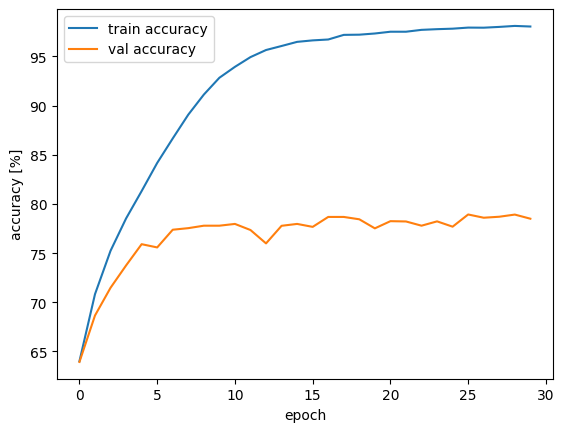

In [19]:
plt.plot(train_accuracies, label = 'train accuracy')
plt.plot(val_accuracies, label = 'val accuracy')

plt.xlabel('epoch')
plt.ylabel('accuracy [%]')

plt.legend()
plt.show()

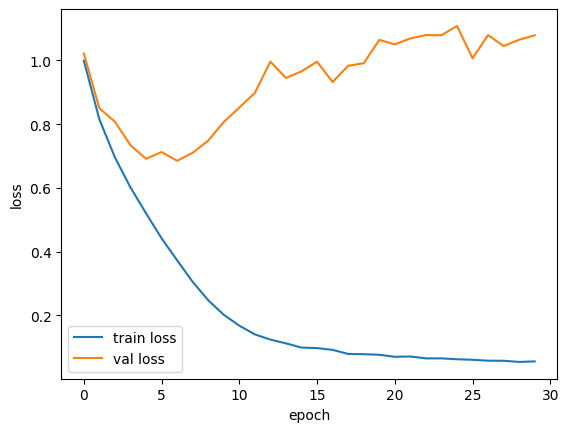

In [20]:
plt.plot(train_losses, label = 'train loss')
plt.plot(val_losses, label = 'val loss')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()
plt.show()